<a href="https://colab.research.google.com/github/aexomir/AML_mistake_detection/blob/feat%2Frnn/notebooks/rnn_baseline_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Baseline Training for CaptainCook4D SupervisedER

Train RNN/LSTM baseline for mistake detection and compare against MLP and Transformer baselines.

## Workflow:
1. Setup repository and dependencies
2. Load features and annotations from HuggingFace
3. Train RNN models (Omnivore + SlowFast)
4. Evaluate and compare results

## Prerequisites:
- Set Colab secrets: `WANDB_API_KEY`, `HF_TOKEN`
- HuggingFace datasets: features and annotations
- Run all cells sequentially


In [1]:
# ============================================
# CONFIGURE YOUR REPOSITORY
# ============================================
# Option 1: Clone from GitHub (recommended)
REPO_URL = "https://github.com/aexomir/AML_mistake_detection.git"
REPO_BRANCH = "feat/rnn"  # Leave empty for default branch, or specify branch name

# Option 2: Manual upload - set REPO_URL to empty string and upload files manually
# REPO_URL = ""

REPO_DIR = "code"

print(f"Repository URL: {REPO_URL if REPO_URL else 'Manual upload mode'}")
print(f"Repository branch: {REPO_BRANCH if REPO_BRANCH else 'default'}")
print(f"Repository directory: {REPO_DIR}")


Repository URL: https://github.com/aexomir/AML_mistake_detection.git
Repository branch: feat/rnn
Repository directory: code


In [2]:
import os
import shutil

# Remove existing directory if it exists
if os.path.exists(REPO_DIR):
    print(f"Removing existing {REPO_DIR} directory...")
    shutil.rmtree(REPO_DIR)

# Clone repository
if REPO_URL:
    print(f"Cloning repository from {REPO_URL}...")
    clone_cmd = f"git clone {REPO_URL} {REPO_DIR}"
    result = os.system(clone_cmd)

    if result != 0:
        print(f"⚠ Clone failed. Please check the URL or upload files manually.")
        os.makedirs(REPO_DIR, exist_ok=True)
    else:
        print("✓ Repository cloned successfully")

        # Checkout specific branch if specified
        if REPO_BRANCH:
            print(f"Checking out branch: {REPO_BRANCH}")
            os.chdir(REPO_DIR)
            os.system(f"git checkout {REPO_BRANCH}")
            os.chdir('..')
            print(f"✓ Switched to branch: {REPO_BRANCH}")
else:
    print("Manual upload mode: Creating directory...")
    os.makedirs(REPO_DIR, exist_ok=True)

# Change to repository directory
if os.path.exists(REPO_DIR):
    os.chdir(REPO_DIR)
    print(f"\n✓ Changed to directory: {os.getcwd()}")
    print(f"\nRepository contents:")
    !ls -la
else:
    print(f"✗ Error: {REPO_DIR} directory not found!")


Cloning repository from https://github.com/aexomir/AML_mistake_detection.git...
✓ Repository cloned successfully
Checking out branch: feat/rnn
✓ Switched to branch: feat/rnn

✓ Changed to directory: /content/code

Repository contents:
total 6024
drwxr-xr-x 9 root root    4096 Dec 27 06:41 .
drwxr-xr-x 1 root root    4096 Dec 27 06:41 ..
-rw-r--r-- 1 root root 6042142 Dec 27 06:41 3_Mistake_Detection.pdf
drwxr-xr-x 3 root root    4096 Dec 27 06:41 analysis
-rw-r--r-- 1 root root   20480 Dec 27 06:41 base.py
-rw-r--r-- 1 root root    1685 Dec 27 06:41 constants.py
drwxr-xr-x 3 root root    4096 Dec 27 06:41 core
drwxr-xr-x 2 root root    4096 Dec 27 06:41 dataloader
-rw-r--r-- 1 root root    6148 Dec 27 06:41 .DS_Store
drwxr-xr-x 2 root root    4096 Dec 27 06:41 er_annotations
drwxr-xr-x 8 root root    4096 Dec 27 06:41 .git
-rw-r--r-- 1 root root      65 Dec 27 06:41 .gitignore
-rwxr-xr-x 1 root root    1904 Dec 27 06:41 install_deps.py
-rw-r--r-- 1 root root   11357 Dec 27 06:41 LICENS

In [3]:
# Verify repository structure
import os

print(f"Current working directory: {os.getcwd()}")
print(f"\nChecking repository structure...")

required_items = [
    'scripts/train_rnn_baseline.py',
    'core/evaluate.py',
    'dataloader',
    'base.py',
    'constants.py'
]

missing = []
for item in required_items:
    if os.path.exists(item):
        print(f"✓ Found: {item}")
    else:
        print(f"✗ Missing: {item}")
        missing.append(item)

if missing:
    print(f"\n⚠ Warning: Some required files/directories are missing!")
    print(f"Please ensure all files are present before proceeding.")
else:
    print(f"\n✓ Repository structure looks good!")


Current working directory: /content/code

Checking repository structure...
✓ Found: scripts/train_rnn_baseline.py
✓ Found: core/evaluate.py
✓ Found: dataloader
✓ Found: base.py
✓ Found: constants.py

✓ Repository structure looks good!


In [4]:
# Install dependencies
# Colab comes with PyTorch pre-installed, so we'll work with that
# Remove PyTorch version constraints to avoid conflicts
if os.path.exists('requirements.txt'):
    !sed -i '/^torch==/d' requirements.txt 2>/dev/null || true
    !sed -i '/^torchvision==/d' requirements.txt 2>/dev/null || true

# Install torcheval (required for evaluation metrics)
!pip install -q torcheval

# Install all remaining dependencies from requirements.txt
if os.path.exists('requirements.txt'):
    !pip install -q -r requirements.txt
elif os.path.exists('requirements-cpu.txt'):
    !pip install -q -r requirements-cpu.txt

# Install additional dependencies for RNN baseline
!pip install -q wandb loguru

print("✓ All dependencies installed successfully")

# Verify PyTorch installation
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.4.59 requires requests-toolbelt>=1.0.0, but you have requests-toolbelt 0.10.1 which is incompatible.
✓ All dependencies installed success

In [5]:
# HuggingFace Configuration (placeholder - will be set after authentication)
HF_USERNAME = None
HF_DATASET_REPO = None
HF_BASELINES_REPO = None

print("="*60)
print("HuggingFace Configuration")
print("="*60)
print("Configuration will be set after authentication")
print("="*60)


HuggingFace Configuration
Configuration will be set after authentication


In [6]:
## 2.5. Authentication & HuggingFace Setup


In [7]:
# Authentication Configuration
from google.colab import userdata
from huggingface_hub import HfApi

WANDB_API_KEY = userdata.get('WANDB_API_KEY')
HF_TOKEN = userdata.get('HF_TOKEN')

print("="*60)
print("Authentication")
print("="*60)

if WANDB_API_KEY:
    print(f"✓ WANDB_API_KEY: {WANDB_API_KEY[:8]}...{WANDB_API_KEY[-4:]}")
else:
    print("✗ WANDB_API_KEY not found")

if HF_TOKEN:
    print(f"✓ HF_TOKEN: {HF_TOKEN[:8]}...{HF_TOKEN[-4:]}")
else:
    print("✗ HF_TOKEN not found")

print("="*60)

if not WANDB_API_KEY or not HF_TOKEN:
    raise ValueError("Missing required secrets in Colab")

# Auto-detect HF username
api = HfApi(token=HF_TOKEN)
HF_USERNAME = api.whoami()['name']
print(f"✓ HuggingFace user: {HF_USERNAME}")

# Update repo configs
HF_DATASET_REPO = f"{HF_USERNAME}/captaincook4d-features"
HF_BASELINES_REPO = f"{HF_USERNAME}/captaincook4d-baselines"

print(f"✓ Dataset repo: {HF_DATASET_REPO}")
print(f"✓ Baselines repo: {HF_BASELINES_REPO}")


Authentication
✓ WANDB_API_KEY: 915aca48...5dc9
✓ HF_TOKEN: hf_UxVaU...XnDu
✓ HuggingFace user: aexomir
✓ Dataset repo: aexomir/captaincook4d-features
✓ Baselines repo: aexomir/captaincook4d-baselines


In [8]:
# Create data directory structure
import os

os.makedirs('data/video/omnivore', exist_ok=True)
os.makedirs('data/video/slowfast', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('annotations/annotation_json', exist_ok=True)
os.makedirs('annotations/data_splits', exist_ok=True)
os.makedirs('er_annotations', exist_ok=True)

print("✓ Directory structure created")


✓ Directory structure created


In [9]:
# Load features from HuggingFace
from huggingface_hub import hf_hub_download
import zipfile
import os
import shutil

print("="*60)
print("Loading Features from HuggingFace")
print("="*60)

def extract_features(zip_path, target_dir, feature_name):
    """Extract features and handle nested folder structure"""
    # Clean target directory
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)

    # Extract to parent directory
    parent_dir = os.path.dirname(target_dir)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(parent_dir)

    # Check if nested folder exists and fix it
    nested_path = os.path.join(target_dir, feature_name)
    if os.path.exists(nested_path) and os.path.isdir(nested_path):
        # Move contents up one level
        for item in os.listdir(nested_path):
            shutil.move(os.path.join(nested_path, item), os.path.join(target_dir, item))
        # Remove empty nested folder
        os.rmdir(nested_path)

    # Count features
    count = len([f for f in os.listdir(target_dir) if f.endswith('.npz')])
    return count

# Download and extract omnivore features
print("Downloading omnivore features...")
omnivore_zip = hf_hub_download(
    repo_id=HF_DATASET_REPO,
    filename="omnivore.zip",
    repo_type="dataset",
    token=HF_TOKEN
)
omnivore_count = extract_features(omnivore_zip, 'data/video/omnivore', 'omnivore')
print(f"✓ Extracted {omnivore_count} omnivore features")

# Download and extract slowfast features
print("Downloading slowfast features...")
slowfast_zip = hf_hub_download(
    repo_id=HF_DATASET_REPO,
    filename="slowfast.zip",
    repo_type="dataset",
    token=HF_TOKEN
)
slowfast_count = extract_features(slowfast_zip, 'data/video/slowfast', 'slowfast')
print(f"✓ Extracted {slowfast_count} slowfast features")

print("="*60)


Loading Features from HuggingFace


omnivore.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

✓ Extracted 384 omnivore features


slowfast.zip:   0%|          | 0.00/505M [00:00<?, ?B/s]

✓ Extracted 384 slowfast features


In [10]:
# Load annotations (HuggingFace or Git repository)
import os
import zipfile
from huggingface_hub import hf_hub_download

print("="*60)
print("Loading Annotations")
print("="*60)

try:
    print("Attempting to load from HuggingFace...")
    annotations_zip = hf_hub_download(
        repo_id=HF_DATASET_REPO,
        filename="annotations.zip",
        repo_type="dataset",
        token=HF_TOKEN
    )

    with zipfile.ZipFile(annotations_zip, 'r') as z:
        z.extractall('.')

    print("✓ Loaded annotations from HuggingFace")
except Exception as e:
    print(f"Note: {e}")
    print("Using annotations from Git repository")

# Verify required annotation files
required_files = [
    'annotations/annotation_json/step_annotations.json',
    'annotations/annotation_json/error_annotations.json',
    'er_annotations/recordings_combined_splits.json'
]

missing = []
for file in required_files:
    if os.path.exists(file):
        print(f"✓ {file}")
    else:
        print(f"✗ Missing: {file}")
        missing.append(file)

if missing:
    print(f"\n⚠ Warning: {len(missing)} file(s) missing!")
else:
    print("\n✓ All annotation files present")

print("="*60)


Loading Annotations
Attempting to load from HuggingFace...


annotations.zip:   0%|          | 0.00/823k [00:00<?, ?B/s]

✓ Loaded annotations from HuggingFace
✓ annotations/annotation_json/step_annotations.json
✓ annotations/annotation_json/error_annotations.json
✓ er_annotations/recordings_combined_splits.json

✓ All annotation files present


## 2.6. HuggingFace Helper Functions


In [11]:
# Initialize WandB authentication
import wandb

wandb.login(key=WANDB_API_KEY)
print("✓ WandB authenticated")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aexomir (aexomir-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ WandB authenticated


In [12]:
# HuggingFace Helper Functions
from huggingface_hub import upload_file, upload_folder, create_repo, hf_hub_download, HfApi
import os
import time

def get_hf_repo_name(wandb_run_name, backbone):
    return f"{HF_USERNAME}/rnn-{backbone}-{wandb_run_name}"

def ensure_hf_repo_exists(repo_id, token):
    """Ensure HuggingFace repository exists, create if needed"""
    api = HfApi(token=token)
    try:
        # Check if repo exists
        api.repo_info(repo_id=repo_id, repo_type="model")
        print(f"✓ Repository already exists: {repo_id}")
        return True
    except Exception:
        # Repo doesn't exist, create it
        try:
            print(f"Creating repository: {repo_id}")
            api.create_repo(repo_id=repo_id, private=True, exist_ok=True, repo_type="model")
            time.sleep(2)  # Wait for repo to be ready
            # Verify it was created
            api.repo_info(repo_id=repo_id, repo_type="model")
            print(f"✓ Repository created: {repo_id}")
            return True
        except Exception as e:
            print(f"✗ Failed to create repo: {e}")
            return False

def upload_checkpoints_to_hf(local_path, wandb_run_name, backbone):
    print("="*60)
    print(f"Uploading to HuggingFace: {backbone}")
    print("="*60)

    # Verify checkpoint path exists
    if not os.path.exists(local_path):
        print(f"✗ Checkpoint path not found: {local_path}")
        print(f"  Current directory: {os.getcwd()}")
        print(f"  Absolute path would be: {os.path.abspath(local_path)}")
        return False

    # List all files in directory for debugging
    all_files = os.listdir(local_path)
    print(f"  Files in directory: {all_files}")

    checkpoint_files = [f for f in all_files if f.endswith('.pt')]
    if not checkpoint_files:
        print(f"✗ No checkpoint files found in {local_path}")
        print(f"  Directory contains: {all_files}")
        return False

    print(f"  Found {len(checkpoint_files)} checkpoint file(s): {checkpoint_files}")

    repo_id = get_hf_repo_name(wandb_run_name, backbone)

    # Ensure repository exists before uploading
    if not ensure_hf_repo_exists(repo_id, HF_TOKEN):
        print(f"✗ Failed to ensure repository exists: {repo_id}")
        return False

    try:
        upload_folder(folder_path=local_path, repo_id=repo_id, token=HF_TOKEN, allow_patterns="*.pt")
        print(f"✓ Uploaded {len(checkpoint_files)} checkpoints to {repo_id}")
        return True
    except Exception as e:
        print(f"✗ Upload failed: {e}")
        return False

def download_checkpoint_from_hf(repo_id, filename):
    try:
        return hf_hub_download(repo_id=repo_id, filename=filename, repo_type="model", token=HF_TOKEN)
    except Exception as e:
        print(f"✗ Download failed: {e}")
        return None

def upload_results_to_hf(csv_path, wandb_run_name, backbone):
    if not os.path.exists(csv_path):
        return False

    repo_id = get_hf_repo_name(wandb_run_name, backbone)

    # Ensure repository exists
    if not ensure_hf_repo_exists(repo_id, HF_TOKEN):
        return False

    try:
        upload_file(path_or_fileobj=csv_path, path_in_repo="results.csv", repo_id=repo_id, token=HF_TOKEN)
        return True
    except Exception as e:
        print(f"✗ Results upload failed: {e}")
        return False

def create_model_card(wandb_run_name, backbone, config, wandb_url):
    repo_id = get_hf_repo_name(wandb_run_name, backbone)

    # Ensure repository exists before uploading model card
    if not ensure_hf_repo_exists(repo_id, HF_TOKEN):
        print(f"✗ Cannot upload model card: repository does not exist")
        return False

    card = f"""---
tags:
- video-understanding
- error-recognition
- rnn
datasets:
- {HF_DATASET_REPO}
---

# RNN Baseline: {backbone.upper()}

## Model Details
- Backbone: {backbone}
- Architecture: {config['rnn_type']}
- Hidden Size: {config['rnn_hidden_size']}
- Layers: {config['rnn_num_layers']}

## Training
- WandB Run: {wandb_url}
- Epochs: {config['num_epochs']}
- Learning Rate: {config['learning_rate']}

## Results
See results.csv for detailed metrics.
"""

    try:
        # Write to temporary file first, then upload
        import tempfile
        with tempfile.NamedTemporaryFile(mode='w', suffix='.md', delete=False) as tmp_file:
            tmp_file.write(card)
            tmp_path = tmp_file.name

        upload_file(path_or_fileobj=tmp_path, path_in_repo="README.md", repo_id=repo_id, token=HF_TOKEN)
        os.unlink(tmp_path)  # Clean up temp file
        print(f"✓ Model card uploaded to {repo_id}")
        return True
    except Exception as e:
        print(f"✗ Model card upload failed: {e}")
        return False

def get_wandb_run_with_retry(project_name, max_retries=3, initial_delay=1):
    """Retrieve WandB run with retry logic"""
    import wandb

    for attempt in range(max_retries):
        try:
            api = wandb.Api()
            runs = api.runs(project_name, order="-created_at", per_page=1)
            if runs and len(runs) > 0 and runs[0].name:
                print(f"✓ Retrieved WandB run: {runs[0].name} (attempt {attempt + 1})")
                return runs[0]
            else:
                if attempt < max_retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"  Run not available yet, waiting {delay}s before retry {attempt + 2}/{max_retries}...")
                    time.sleep(delay)
                    continue
        except Exception as e:
            if attempt < max_retries - 1:
                delay = initial_delay * (2 ** attempt)
                print(f"  Error retrieving run: {e}, waiting {delay}s before retry {attempt + 2}/{max_retries}...")
                time.sleep(delay)
                continue
            else:
                print(f"✗ Failed to retrieve WandB run after {max_retries} attempts: {e}")
                raise

    print(f"✗ No WandB run found after {max_retries} attempts")
    return None

print("✓ HuggingFace helper functions loaded")


✓ HuggingFace helper functions loaded


## 3. Train RNN Baseline with Omnivore Features


In [14]:
# Training Configuration
TRAINING_CONFIG = {
    "batch_size": 4,
    "num_epochs": 20,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "rnn_hidden_size": 256,
    "rnn_num_layers": 2,
    "rnn_dropout": 0.2,
    "rnn_bidirectional": True,
    "rnn_type": "LSTM"
}

print("="*60)
print("Training Configuration")
print("="*60)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)

Training Configuration
  batch_size: 4
  num_epochs: 20
  learning_rate: 0.001
  weight_decay: 0.001
  rnn_hidden_size: 256
  rnn_num_layers: 2
  rnn_dropout: 0.2
  rnn_bidirectional: True
  rnn_type: LSTM


In [19]:
# Pre-training checks for Omnivore
import os
from google.colab import userdata
from huggingface_hub import HfApi
import wandb

print("="*60)
print("Pre-training Checks: Omnivore")
print("="*60)

checks_passed = True

if not os.path.exists("scripts/train_rnn_baseline.py"):
    print("✗ Training script not found")
    checks_passed = False
else:
    print("✓ Training script found")

os.makedirs("checkpoints/error_recognition/RNN/omnivore", exist_ok=True)
try:
    test_file = "checkpoints/error_recognition/RNN/omnivore/.test_write"
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print("✓ Checkpoint directory writable")
except Exception as e:
    print(f"✗ Checkpoint directory not writable: {e}")
    checks_passed = False

try:
    test_key = userdata.get('WANDB_API_KEY')
    if not test_key:
        print("✗ WANDB_API_KEY not found in userdata")
        checks_passed = False
    else:
        print("✓ WANDB_API_KEY available")
except Exception as e:
    print(f"✗ Failed to get WANDB_API_KEY: {e}")
    checks_passed = False

try:
    test_token = userdata.get('HF_TOKEN')
    if not test_token:
        print("✗ HF_TOKEN not found in userdata")
        checks_passed = False
    else:
        print("✓ HF_TOKEN available")
except Exception as e:
    print(f"✗ Failed to get HF_TOKEN: {e}")
    checks_passed = False

if not wandb.api.api_key:
    print("✗ WandB not authenticated")
    checks_passed = False
else:
    print("✓ WandB authenticated")

try:
    api = wandb.Api()
    viewer = api.viewer
    entity = viewer.entity if hasattr(viewer, 'entity') else None
    if entity:
        print(f"✓ WandB API accessible (entity: {entity})")
    else:
        print("✓ WandB API accessible")
except Exception as e:
    print(f"✗ WandB API not accessible: {e}")
    checks_passed = False

try:
    hf_token = userdata.get('HF_TOKEN')
    hf_api = HfApi(token=hf_token)
    hf_api.whoami()
    print("✓ HuggingFace token valid")
except Exception as e:
    print(f"✗ HuggingFace token invalid: {e}")
    checks_passed = False

try:
    assert 'upload_checkpoints_to_hf' in globals()
    assert 'create_model_card' in globals()
    print("✓ HuggingFace helper functions available")
except AssertionError:
    print("✗ HuggingFace helper functions not available")
    checks_passed = False

try:
    assert 'TRAINING_CONFIG' in globals()
    print("✓ TRAINING_CONFIG defined")
except AssertionError:
    print("✗ TRAINING_CONFIG not defined")
    checks_passed = False

required_data = [
    "data/video/omnivore",
    "er_annotations/recordings_combined_splits.json"
]

for path in required_data:
    if not os.path.exists(path):
        print(f"✗ Missing: {path}")
        checks_passed = False
    else:
        print(f"✓ Found: {path}")

if not checks_passed:
    raise RuntimeError("Pre-training checks failed")

print("="*60)
print("✓ All pre-training checks passed")
print("="*60)


Pre-training Checks: Omnivore
✓ Training script found
✓ Checkpoint directory writable
✓ WANDB_API_KEY available
✓ HF_TOKEN available
✓ WandB authenticated
✓ WandB API accessible (entity: aexomir-politecnico-di-torino)
✓ HuggingFace token valid
✓ HuggingFace helper functions available
✓ TRAINING_CONFIG defined
✓ Found: data/video/omnivore
✓ Found: er_annotations/recordings_combined_splits.json
✓ All pre-training checks passed


In [20]:
# Train RNN with Omnivore features
import subprocess
import sys
import os
import wandb
from google.colab import userdata

BACKBONE = "omnivore"

print(f"{'='*60}")
print(f"Training RNN + {BACKBONE.upper()}")
print(f"{'='*60}")

cmd = [
    sys.executable, "scripts/train_rnn_baseline.py",
    "--variant", "RNN",
    "--backbone", BACKBONE,
    "--split", "recordings",
    "--ckpt_directory", "checkpoints",
    "--batch_size", str(TRAINING_CONFIG["batch_size"]),
    "--num_epochs", str(TRAINING_CONFIG["num_epochs"]),
    "--lr", str(TRAINING_CONFIG["learning_rate"]),
    "--weight_decay", str(TRAINING_CONFIG["weight_decay"]),
    "--rnn_hidden_size", str(TRAINING_CONFIG["rnn_hidden_size"]),
    "--rnn_num_layers", str(TRAINING_CONFIG["rnn_num_layers"]),
    "--rnn_dropout", str(TRAINING_CONFIG["rnn_dropout"]),
    "--rnn_bidirectional", str(TRAINING_CONFIG["rnn_bidirectional"]),
    "--rnn_type", TRAINING_CONFIG["rnn_type"],
]

env = os.environ.copy()
env['PYTHONPATH'] = os.getcwd() + (os.pathsep + env.get('PYTHONPATH', ''))
env['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')

result = subprocess.run(cmd, cwd=os.getcwd(), env=env, check=False,
                      stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

if result.stdout:
    print(result.stdout)

Streaming output truncated to the last 5000 lines.
Train Epoch: 19, Progress: 990/993, Loss: 0.042954:  99%|█████████▉| 986/993 [00:32<00:00, 42.07it/s]
Train Epoch: 19, Progress: 991/993, Loss: 0.531546:  99%|█████████▉| 986/993 [00:32<00:00, 42.07it/s]
Train Epoch: 19, Progress: 992/993, Loss: 1.941815:  99%|█████████▉| 986/993 [00:32<00:00, 42.07it/s]
Train Epoch: 19, Progress: 992/993, Loss: 1.941815: 100%|██████████| 993/993 [00:32<00:00, 46.58it/s]
Train Epoch: 19, Progress: 992/993, Loss: 1.941815: 100%|██████████| 993/993 [00:32<00:00, 30.50it/s]

val Progress: 681/681: 100%|██████████| 681/681 [00:07<00:00, 92.94it/s] 
----------------------------------------------------------------
val Sub Step Level Metrics: {'precision': 0.42857142857142855, 'recall': 0.3574468085106383, 'f1': 0.38979118329466356, 'accuracy': 0.6138032305433186, 'auc': np.float64(0.6260662150558153), 'pr_auc': tensor(0.4511)}
val Step Level Metrics: {'precision': 0.46285714285714286, 'recall': 0.34468085106

AttributeError: 'function' object has no attribute 'entity'

In [28]:


if result.returncode == 0:
    local_ckpt_path = f"checkpoints/error_recognition/RNN/{BACKBONE}"
    project_name = f"error_recognition_recordings_{BACKBONE}_RNN_video"
    # viewer = wandb.api.viewer()
    # entity = viewer.entity
    full_project_name = f"{entity}/{project_name}"

    # Use retry logic to get WandB run
    print(f"\n{'='*60}")
    print("Retrieving WandB run information...")
    print(f"{'='*60}")
    wandb_run = get_wandb_run_with_retry(full_project_name, max_retries=3, initial_delay=1)

    if wandb_run:
        wandb_run_name = wandb_run.name
        wandb_run_url = wandb_run.url
        print(f"✓ WandB run: {wandb_run_name}")
        print(f"✓ WandB URL: {wandb_run_url}")

        # Upload checkpoints and model card
        upload_checkpoints_to_hf(local_ckpt_path, wandb_run_name, BACKBONE)
        create_model_card(wandb_run_name, BACKBONE, TRAINING_CONFIG, wandb_run_url)
    else:
        print("✗ Failed to retrieve WandB run, skipping HuggingFace upload")
else:
    print(f"✗ Training failed with return code {result.returncode}")

<module 'wandb' from '/usr/local/lib/python3.12/dist-packages/wandb/__init__.py'>

Retrieving WandB run information...
✓ Retrieved WandB run: fast-dragon-19 (attempt 1)
✓ WandB run: fast-dragon-19
✓ WandB URL: https://wandb.ai/aexomir-politecnico-di-torino/error_recognition_recordings_omnivore_RNN_video/runs/xn0to9vl
Uploading to HuggingFace: omnivore
  Files in directory: ['error_recognition_recordings_omnivore_RNN_video_epoch_20.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_6.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_18.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_15.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_13.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_3.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_7.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_2.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_4.pt', 'error_recognition_recordings_omnivore_RNN_video_epoch_16.pt'

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...vore_RNN_video_epoch_1.pt:   1%|1         |  182kB / 17.9MB            

  ...ore_RNN_video_epoch_18.pt:   1%|1         |  182kB / 17.9MB            

  ...ore_RNN_video_epoch_20.pt:   1%|1         |  182kB / 17.9MB            

  ...mnivore_RNN_video_best.pt:   1%|1         |  183kB / 17.9MB            

  ...ore_RNN_video_epoch_19.pt:   1%|1         |  183kB / 17.9MB            

  ...vore_RNN_video_epoch_2.pt:   1%|1         |  183kB / 17.9MB            

  ...ore_RNN_video_epoch_10.pt:   1%|1         |  184kB / 17.9MB            

  ...vore_RNN_video_epoch_3.pt:   1%|1         |  184kB / 17.9MB            

  ...vore_RNN_video_epoch_9.pt:   1%|1         |  184kB / 17.9MB            

  ...ore_RNN_video_epoch_12.pt:   1%|1         |  185kB / 17.9MB            

✓ Uploaded 21 checkpoints to aexomir/rnn-omnivore-fast-dragon-19
✓ Repository already exists: aexomir/rnn-omnivore-fast-dragon-19
✓ Model card uploaded to aexomir/rnn-omnivore-fast-dragon-19


In [30]:
# Pre-training checks for SlowFast
import os
from google.colab import userdata
from huggingface_hub import HfApi
import wandb

print("="*60)
print("Pre-training Checks: SlowFast")
print("="*60)

checks_passed = True

if not os.path.exists("scripts/train_rnn_baseline.py"):
    print("✗ Training script not found")
    checks_passed = False
else:
    print("✓ Training script found")

os.makedirs("checkpoints/error_recognition/RNN/slowfast", exist_ok=True)
try:
    test_file = "checkpoints/error_recognition/RNN/slowfast/.test_write"
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print("✓ Checkpoint directory writable")
except Exception as e:
    print(f"✗ Checkpoint directory not writable: {e}")
    checks_passed = False

try:
    test_key = userdata.get('WANDB_API_KEY')
    if not test_key:
        print("✗ WANDB_API_KEY not found in userdata")
        checks_passed = False
    else:
        print("✓ WANDB_API_KEY available")
except Exception as e:
    print(f"✗ Failed to get WANDB_API_KEY: {e}")
    checks_passed = False

try:
    test_token = userdata.get('HF_TOKEN')
    if not test_token:
        print("✗ HF_TOKEN not found in userdata")
        checks_passed = False
    else:
        print("✓ HF_TOKEN available")
except Exception as e:
    print(f"✗ Failed to get HF_TOKEN: {e}")
    checks_passed = False

if not wandb.api.api_key:
    print("✗ WandB not authenticated")
    checks_passed = False
else:
    print("✓ WandB authenticated")

try:
    api = wandb.Api()
    viewer = api.viewer
    entity = viewer.entity if hasattr(viewer, 'entity') else None
    if entity:
        print(f"✓ WandB API accessible (entity: {entity})")
    else:
        print("✓ WandB API accessible")
except Exception as e:
    print(f"✗ WandB API not accessible: {e}")
    checks_passed = False

try:
    hf_token = userdata.get('HF_TOKEN')
    hf_api = HfApi(token=hf_token)
    hf_api.whoami()
    print("✓ HuggingFace token valid")
except Exception as e:
    print(f"✗ HuggingFace token invalid: {e}")
    checks_passed = False

try:
    assert 'upload_checkpoints_to_hf' in globals()
    assert 'create_model_card' in globals()
    print("✓ HuggingFace helper functions available")
except AssertionError:
    print("✗ HuggingFace helper functions not available")
    checks_passed = False

try:
    assert 'TRAINING_CONFIG' in globals()
    print("✓ TRAINING_CONFIG defined")
except AssertionError:
    print("✗ TRAINING_CONFIG not defined")
    checks_passed = False

required_data = [
    "data/video/slowfast",
    "er_annotations/recordings_combined_splits.json"
]

for path in required_data:
    if not os.path.exists(path):
        print(f"✗ Missing: {path}")
        checks_passed = False
    else:
        print(f"✓ Found: {path}")

if not checks_passed:
    raise RuntimeError("Pre-training checks failed")

print("="*60)
print("✓ All pre-training checks passed")
print("="*60)


Pre-training Checks: SlowFast
✓ Training script found
✓ Checkpoint directory writable
✓ WANDB_API_KEY available
✓ HF_TOKEN available
✓ WandB authenticated
✓ WandB API accessible (entity: aexomir-politecnico-di-torino)
✓ HuggingFace token valid
✓ HuggingFace helper functions available
✓ TRAINING_CONFIG defined
✓ Found: data/video/slowfast
✓ Found: er_annotations/recordings_combined_splits.json
✓ All pre-training checks passed


## 4. Train RNN Baseline with SlowFast Features


In [31]:
# Train RNN with SlowFast features
import subprocess
import sys
import os
import wandb
from google.colab import userdata

BACKBONE = "slowfast"

print(f"{'='*60}")
print(f"Training RNN + {BACKBONE.upper()}")
print(f"{'='*60}")

cmd = [
    sys.executable, "scripts/train_rnn_baseline.py",
    "--variant", "RNN",
    "--backbone", BACKBONE,
    "--split", "recordings",
    "--ckpt_directory", "checkpoints",
    "--batch_size", str(TRAINING_CONFIG["batch_size"]),
    "--num_epochs", str(TRAINING_CONFIG["num_epochs"]),
    "--lr", str(TRAINING_CONFIG["learning_rate"]),
    "--weight_decay", str(TRAINING_CONFIG["weight_decay"]),
    "--rnn_hidden_size", str(TRAINING_CONFIG["rnn_hidden_size"]),
    "--rnn_num_layers", str(TRAINING_CONFIG["rnn_num_layers"]),
    "--rnn_dropout", str(TRAINING_CONFIG["rnn_dropout"]),
    "--rnn_bidirectional", str(TRAINING_CONFIG["rnn_bidirectional"]),
    "--rnn_type", TRAINING_CONFIG["rnn_type"],
]

env = os.environ.copy()
env['PYTHONPATH'] = os.getcwd() + (os.pathsep + env.get('PYTHONPATH', ''))
env['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')

result = subprocess.run(cmd, cwd=os.getcwd(), env=env, check=False,
                      stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

if result.stdout:
    print(result.stdout)


Streaming output truncated to the last 5000 lines.
Train Epoch: 19, Progress: 906/993, Loss: 1.198377:  91%|█████████ | 904/993 [00:22<00:02, 42.66it/s]
Train Epoch: 19, Progress: 907/993, Loss: 0.713320:  91%|█████████ | 904/993 [00:22<00:02, 42.66it/s]
Train Epoch: 19, Progress: 908/993, Loss: 0.955848:  91%|█████████ | 904/993 [00:22<00:02, 42.66it/s]
Train Epoch: 19, Progress: 908/993, Loss: 0.955848:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 909/993, Loss: 1.198378:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 910/993, Loss: 0.713318:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 911/993, Loss: 0.955848:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 912/993, Loss: 1.198379:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 913/993, Loss: 0.955848:  92%|█████████▏| 909/993 [00:22<00:02, 39.79it/s]
Train Epoch: 19, Progress: 913/

In [32]:
if result.returncode == 0:
    local_ckpt_path = f"checkpoints/error_recognition/RNN/{BACKBONE}"
    project_name = f"error_recognition_recordings_{BACKBONE}_RNN_video"
    # viewer = wandb.api.viewer()
    # entity = viewer.entity
    full_project_name = f"{entity}/{project_name}"

    # Use retry logic to get WandB run
    print(f"\n{'='*60}")
    print("Retrieving WandB run information...")
    print(f"{'='*60}")
    wandb_run = get_wandb_run_with_retry(full_project_name, max_retries=3, initial_delay=1)

    if wandb_run:
        wandb_run_name = wandb_run.name
        wandb_run_url = wandb_run.url
        print(f"✓ WandB run: {wandb_run_name}")
        print(f"✓ WandB URL: {wandb_run_url}")

        # Upload checkpoints and model card
        upload_checkpoints_to_hf(local_ckpt_path, wandb_run_name, BACKBONE)
        create_model_card(wandb_run_name, BACKBONE, TRAINING_CONFIG, wandb_run_url)
    else:
        print("✗ Failed to retrieve WandB run, skipping HuggingFace upload")
else:
    print(f"✗ Training failed with return code {result.returncode}")


Retrieving WandB run information...
✓ Retrieved WandB run: pleasant-microwave-7 (attempt 1)
✓ WandB run: pleasant-microwave-7
✓ WandB URL: https://wandb.ai/aexomir-politecnico-di-torino/error_recognition_recordings_slowfast_RNN_video/runs/fivaxnyq
Uploading to HuggingFace: slowfast
  Files in directory: ['error_recognition_recordings_slowfast_RNN_video_epoch_13.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_5.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_12.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_7.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_11.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_20.pt', 'error_recognition_recordings_slowfast_RNN_video_best.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_6.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_8.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_19.pt', 'error_recognition_recordings_slowfast_RNN_video_epoch_16.pt', 'error_r

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...lowfast_RNN_video_best.pt:   1%|          |  114kB / 12.8MB            

  ...fast_RNN_video_epoch_1.pt:   1%|          |  114kB / 12.8MB            

  ...ast_RNN_video_epoch_11.pt:   1%|          |  114kB / 12.8MB            

  ...ast_RNN_video_epoch_18.pt:   0%|          | 1.22kB / 12.8MB            

  ...ast_RNN_video_epoch_19.pt:   0%|          | 1.14kB / 12.8MB            

  ...fast_RNN_video_epoch_2.pt:   1%|          |  114kB / 12.8MB            

  ...ast_RNN_video_epoch_20.pt:   1%|          |  111kB / 12.8MB            

  ...fast_RNN_video_epoch_9.pt:   1%|          |  114kB / 12.8MB            

  ...ast_RNN_video_epoch_10.pt:   1%|          |  110kB / 12.8MB            

  ...ast_RNN_video_epoch_12.pt:   1%|          |  110kB / 12.8MB            

✓ Uploaded 21 checkpoints to aexomir/rnn-slowfast-pleasant-microwave-7
✓ Repository already exists: aexomir/rnn-slowfast-pleasant-microwave-7
✓ Model card uploaded to aexomir/rnn-slowfast-pleasant-microwave-7


## 5. Evaluate Trained Model


In [33]:
# Evaluate trained RNN models
import subprocess
import sys
import os

EVAL_THRESHOLD = 0.6

def find_best_checkpoint(backbone):
    local_dir = f"checkpoints/error_recognition/RNN/{backbone}"

    if not os.path.exists(local_dir):
        return None

    checkpoint_files = [f for f in os.listdir(local_dir) if f.endswith('_best.pt')]
    if checkpoint_files:
        return os.path.join(local_dir, checkpoint_files[0])

    checkpoint_files = sorted([f for f in os.listdir(local_dir) if f.endswith('.pt') and 'epoch' in f])
    if checkpoint_files:
        return os.path.join(local_dir, checkpoint_files[-1])

    return None

def evaluate_model(backbone):
    print(f"{'='*60}")
    print(f"Evaluating RNN + {backbone.upper()}")
    print(f"{'='*60}")

    checkpoint_path = find_best_checkpoint(backbone)

    if not checkpoint_path or not os.path.exists(checkpoint_path):
        print(f"✗ No checkpoint found")
        return False

    print(f"Checkpoint: {checkpoint_path}")

    cmd = [
        sys.executable, "-m", "core.evaluate",
        "--variant", "RNN",
        "--backbone", backbone,
        "--split", "recordings",
        "--ckpt", checkpoint_path,
        "--threshold", str(EVAL_THRESHOLD)
    ]

    env = os.environ.copy()
    env['PYTHONPATH'] = os.getcwd() + (os.pathsep + env.get('PYTHONPATH', ''))

    result = subprocess.run(cmd, cwd=os.getcwd(), env=env, check=False)

    if result.returncode != 0:
        print(f"✗ Evaluation failed")
        return False
    else:
        print(f"✓ Evaluation complete")
        return True

print("="*60)
print("RNN Model Evaluation")
print("="*60)

omnivore_success = evaluate_model("omnivore")
slowfast_success = evaluate_model("slowfast")

print(f"\n{'='*60}")
print("Evaluation Summary")
print(f"{'='*60}")
print(f"Omnivore: {'✓' if omnivore_success else '✗'}")
print(f"SlowFast: {'✓' if slowfast_success else '✗'}")
print(f"{'='*60}")


RNN Model Evaluation
Evaluating RNN + OMNIVORE
Checkpoint: checkpoints/error_recognition/RNN/omnivore/error_recognition_recordings_omnivore_RNN_video_best.pt
✓ Evaluation complete
Evaluating RNN + SLOWFAST
Checkpoint: checkpoints/error_recognition/RNN/slowfast/error_recognition_recordings_slowfast_RNN_video_best.pt
✓ Evaluation complete

Evaluation Summary
Omnivore: ✓
SlowFast: ✓


## 6. Compare Results


Comprehensive Model Comparison
Results file: results/error_recognition/combined_results/step_True_substep_True_threshold_0.6.csv

Model Performance Comparison (Recordings Split, Threshold=0.6)

Variant Backbone  Step Precision  Step Recall  Step F1  Step Accuracy  Step AUC
    RNN omnivore            46.6        36.93     41.2          62.15     64.61
    RNN slowfast             0.0         0.00      0.0          64.08     50.00

Best Model (by F1 Score):
Variant: RNN
Backbone: omnivore
F1 Score: 41.2000

Generating Visualizations...


/tmp/ipython-input-500399432.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✓ Saved comparison plot to: model_comparison.png


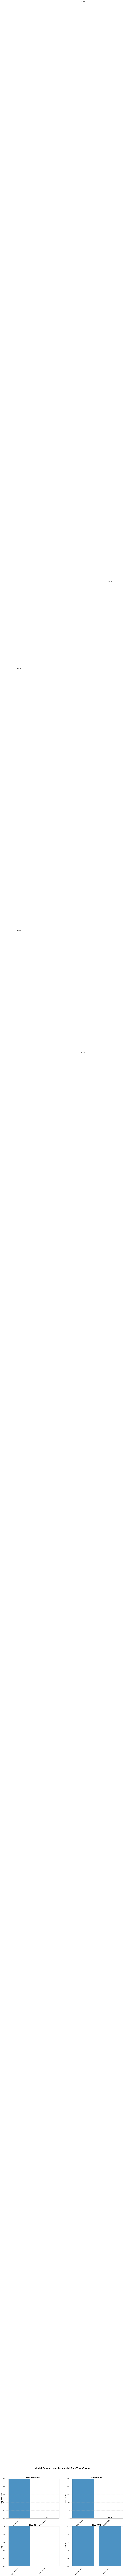

/tmp/ipython-input-500399432.py:153: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✓ Saved F1 comparison plot to: f1_comparison_by_backbone.png


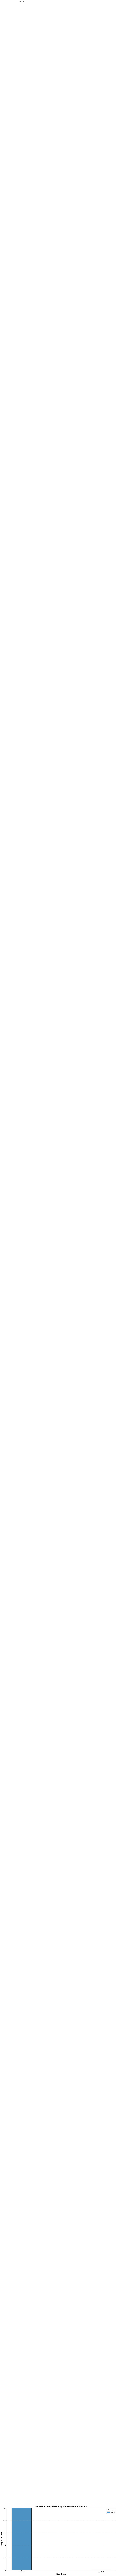


Analysis Complete!

Note: Make sure you've run training and evaluation for all models before comparison.


In [34]:
# Comprehensive results comparison: RNN vs MLP vs Transformer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration
threshold = 0.6
results_file = f"results/error_recognition/combined_results/step_True_substep_True_threshold_{threshold}.csv"

print(f"{'='*80}")
print("Comprehensive Model Comparison")
print(f"{'='*80}")
print(f"Results file: {results_file}")
print()

if not os.path.exists(results_file):
    print(f"⚠ Results file not found: {results_file}")
    print("Please run evaluation first.")
else:
    # Load results
    df = pd.read_csv(results_file)

    # Filter for recordings split
    df_filtered = df[df['Split'] == 'recordings'].copy()

    if len(df_filtered) == 0:
        print("⚠ No results found for 'recordings' split")
    else:
        # Select relevant columns
        columns_to_show = ['Variant', 'Backbone', 'Step Precision', 'Step Recall',
                          'Step F1', 'Step Accuracy', 'Step AUC']

        # Check which columns exist
        existing_columns = [col for col in columns_to_show if col in df_filtered.columns]

        print("="*80)
        print("Model Performance Comparison (Recordings Split, Threshold=0.6)")
        print("="*80)
        print()

        # Display full comparison table
        comparison_df = df_filtered[existing_columns].copy()

        # Sort by F1 score (descending)
        if 'Step F1' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('Step F1', ascending=False)

        # Format numeric columns
        numeric_columns = comparison_df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            comparison_df[col] = comparison_df[col].round(4)

        print(comparison_df.to_string(index=False))
        print()

        # Highlight best model
        if 'Step F1' in comparison_df.columns:
            best_idx = comparison_df['Step F1'].idxmax()
            best_model = comparison_df.loc[best_idx]
            print("="*80)
            print("Best Model (by F1 Score):")
            print("="*80)
            print(f"Variant: {best_model['Variant']}")
            print(f"Backbone: {best_model['Backbone']}")
            print(f"F1 Score: {best_model['Step F1']:.4f}")
            print()

        # Create visualizations
        print("="*80)
        print("Generating Visualizations...")
        print("="*80)

        # Prepare data for plotting
        variants = comparison_df['Variant'].tolist()
        backbones = comparison_df['Backbone'].tolist()
        labels = [f"{v}+{b}" for v, b in zip(variants, backbones)]

        metrics = ['Step Precision', 'Step Recall', 'Step F1', 'Step AUC']
        metrics = [m for m in metrics if m in comparison_df.columns]

        if len(metrics) > 0:
            # Create subplot for each metric
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Model Comparison: RNN vs MLP vs Transformer', fontsize=16, fontweight='bold')

            for idx, metric in enumerate(metrics):
                row = idx // 2
                col = idx % 2
                ax = axes[row, col]

                values = comparison_df[metric].tolist()
                colors = ['#1f77b4' if 'RNN' in label else '#ff7f0e' if 'MLP' in label else '#2ca02c'
                         for label in labels]

                bars = ax.bar(range(len(labels)), values, color=colors, alpha=0.8, edgecolor='black')
                ax.set_xticks(range(len(labels)))
                ax.set_xticklabels(labels, rotation=45, ha='right')
                ax.set_ylabel(metric, fontsize=12)
                ax.set_title(metric, fontsize=13, fontweight='bold')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                ax.set_ylim([0, 1.0])

                # Add value labels on bars
                for bar, val in zip(bars, values):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=9)

            plt.tight_layout()
            plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
            print("✓ Saved comparison plot to: model_comparison.png")
            plt.show()

            # Create grouped bar chart by backbone
            fig, ax = plt.subplots(figsize=(14, 8))

            backbones_unique = sorted(comparison_df['Backbone'].unique())
            variants_unique = sorted(comparison_df['Variant'].unique())

            x = np.arange(len(backbones_unique))
            width = 0.25

            for i, variant in enumerate(variants_unique):
                variant_data = []
                for backbone in backbones_unique:
                    matching = comparison_df[(comparison_df['Variant'] == variant) &
                                            (comparison_df['Backbone'] == backbone)]
                    if len(matching) > 0 and 'Step F1' in matching.columns:
                        variant_data.append(matching['Step F1'].iloc[0])
                    else:
                        variant_data.append(0)

                offset = width * (i - len(variants_unique) / 2 + 0.5)
                bars = ax.bar(x + offset, variant_data, width, label=variant, alpha=0.8, edgecolor='black')

                # Add value labels
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

            ax.set_xlabel('Backbone', fontsize=13, fontweight='bold')
            ax.set_ylabel('Step F1 Score', fontsize=13, fontweight='bold')
            ax.set_title('F1 Score Comparison by Backbone and Variant', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(backbones_unique)
            ax.legend(title='Variant', fontsize=11)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            ax.set_ylim([0, 1.0])

            plt.tight_layout()
            plt.savefig('f1_comparison_by_backbone.png', dpi=150, bbox_inches='tight')
            print("✓ Saved F1 comparison plot to: f1_comparison_by_backbone.png")
            plt.show()

            print()
            print("="*80)
            print("Analysis Complete!")
            print("="*80)
        else:
            print("⚠ No metrics found for visualization")

print()
print("Note: Make sure you've run training and evaluation for all models before comparison.")
